# Prepering Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Import Excel data and choose the relevant columns
df = pd.read_excel(r"C:\Users\noy\OneDrive - mail.tau.ac.il\פרויקט מעבדה\project_data.xlsx", sheet_name="the data")

# Ensure the DataFrame contains 'Occupation' and 'Sleep score' columns
df = df[['Occupation', 'Sleep score']]

# Replace occupation names
df['Occupation'] = df['Occupation'].replace({
    'Health professions': 'Healthcare & Rescue Services',
    'Health Professions': 'Healthcare & Rescue Services',
    'rescue services': 'Healthcare & Rescue Services',
    'Science and Eng.': 'Science & Technology',
    'Information Technologies': 'Science & Technology',
    'HighTech': 'Science & Technology',
    'HIghTech': 'Science & Technology',
    'Machine professional': 'Science & Technology',
    'Business and finances': 'Business & Management',
    'Junior management': 'Business & Management',
    'Junior Management': 'Business & Management',
    'Senior Management': 'Business & Management',
    'Service and sales': 'Service & Sales',
    'Agriculture': 'Arts, Sports & Communication',
    'Sports': 'Arts, Sports & Communication',
    'Performing arts': 'Arts, Sports & Communication',
    'Design, craft & cooking': 'Arts, Sports & Communication',
    'journalism and translation': 'Arts, Sports & Communication',
    'Retired': 'Retired and Unemployed',
    'Unemployed': 'Retired and Unemployed',
    'government': 'Government',
})

# Remove rows with missing values in 'Sleep score'
df = df.dropna(subset=['Sleep score'])

### Sleep Score Distribution by Occupation

# Generating Correlations Plots

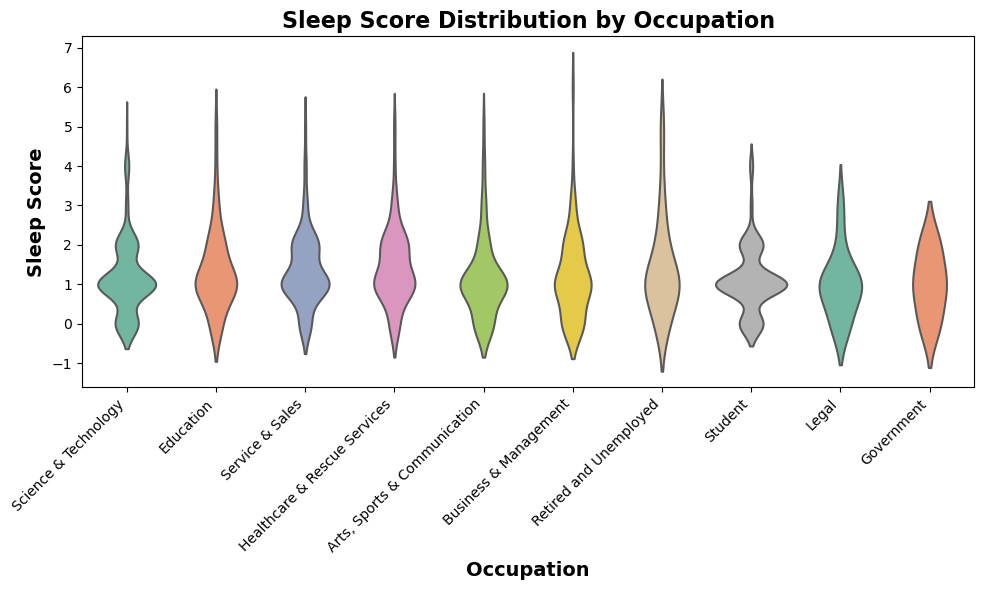

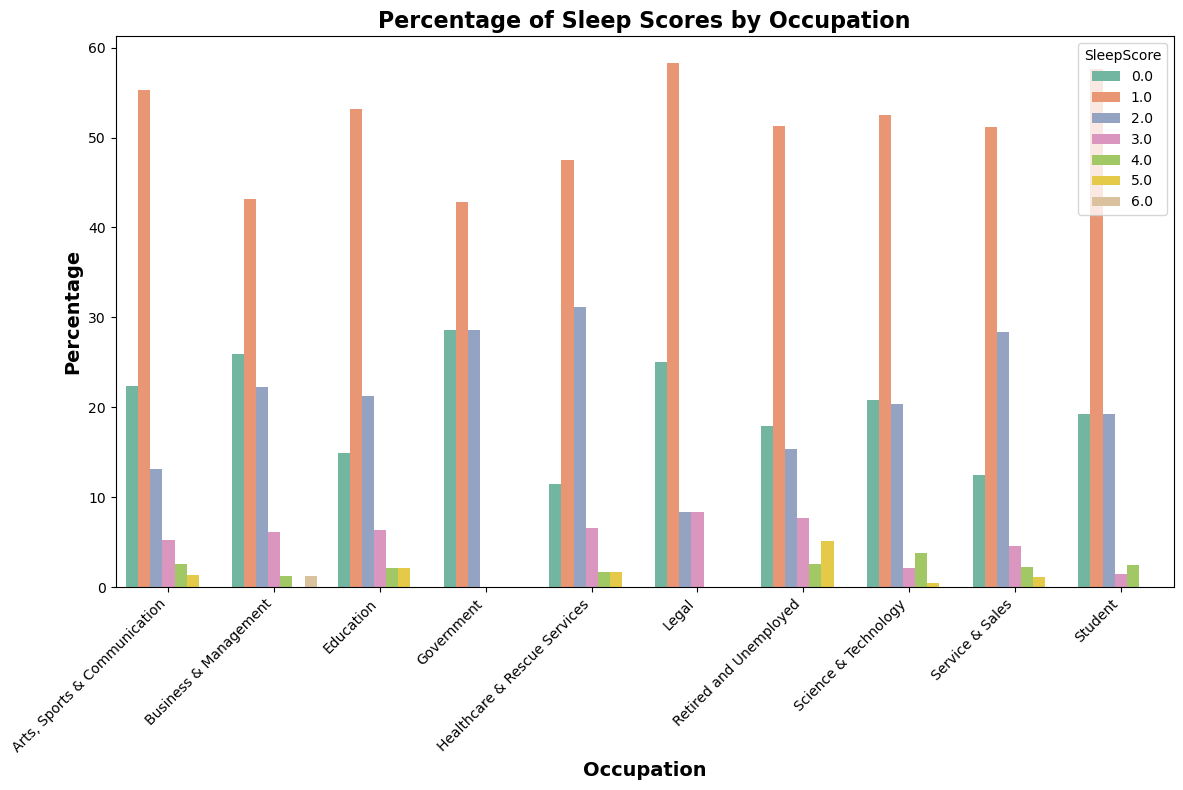

In [2]:
display(Markdown("### Sleep Score Distribution by Occupation"))

# Convert Sleep score to numeric if needed
df['Sleep score'] = pd.to_numeric(df['Sleep score'], errors='coerce')

# Set up the violin plot without internal lines (no median, no quartiles)
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

# Create a violin plot without internal statistics (no median lines, no quartiles)
sns.violinplot(x='Occupation', y='Sleep score', data=df, inner=None, palette='Set2')

# Set title and labels
plt.title('Sleep Score Distribution by Occupation', fontsize=16, fontweight='bold')
plt.xlabel('Occupation', fontsize=14, fontweight='bold')
plt.ylabel('Sleep Score', fontsize=14, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Apply a tight layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Convert AnxietyScore to categorical
df['SleepScore'] = df['Sleep score'].astype('category')

# Calculate percentage of each sleep score for each occupation
count_df = df.groupby(['SleepScore', 'Occupation']).size().reset_index(name='Count')
total_counts = count_df.groupby('Occupation')['Count'].sum().reset_index(name='Total')
count_df = pd.merge(count_df, total_counts, on='Occupation')
count_df['Percentage'] = (count_df['Count'] / count_df['Total']) * 100

# Set up the figure for the bar plot
plt.figure(figsize=(12, 8))

# Create the bar plot showing percentages of sleep scores
sns.barplot(x='Occupation', y='Percentage', hue='SleepScore', data=count_df, palette='Set2')

# Set title and labels
plt.title('Percentage of Sleep Scores by Occupation', fontsize=16, fontweight='bold')
plt.xlabel('Occupation', fontsize=14, fontweight='bold')
plt.ylabel('Percentage', fontsize=14, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Apply a tight layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Performing ANOVA Test

In [3]:
# Perform ANOVA
model = ols('Count ~ C(Occupation) + C(SleepScore)', data=count_df).fit()
anova_table_raw = sm.stats.anova_lm(model, type=2)

def highlight_significant(p_value, threshold=0.05):
    color = 'background-color: #80aaff' if p_value < threshold else ''
    return color
anova_table_styled = anova_table_raw.style.applymap(highlight_significant, subset=['PR(>F)'])

display(Markdown("### ANOVA Results: Analyzing the Effect of Sleep Score and Occupation"))
display(anova_table_styled)
print('Significant cells are highlighted in color.\n')

occupation_p_value = anova_table_raw.at['C(Occupation)', 'PR(>F)']
sleep_score_p_value = anova_table_raw.at['C(SleepScore)', 'PR(>F)']

### ANOVA Results: Analyzing the Effect of Sleep Score and Occupation

,df,sum_sq,mean_sq,F,PR(>F)
C(Occupation),9.000000,7482.857143,831.428571,3.421740,0.002151
C(SleepScore),6.000000,15640.571429,2606.761905,10.728116,0.000000
Residual,54.000000,13121.142857,242.984127,nan,nan


Significant cells are highlighted in color.



# Performing Tukey's Test

In [4]:
# Perform Post Hoc tests
if occupation_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Occupation"))
    tukey_results_prof = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['Occupation'], alpha=0.05)
    tukey_results_prof_df = pd.DataFrame(tukey_results_prof.summary().data[1:], columns=tukey_results_prof.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == True]
    reject_false_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == False]

    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

if sleep_score_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Sleep Score"))
    tukey_results_sleep_score = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['SleepScore'], alpha=0.05)
    tukey_results_sleep_score_df = pd.DataFrame(tukey_results_sleep_score.summary().data[1:], columns=tukey_results_sleep_score.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_sleep_score_df[tukey_results_sleep_score_df['reject'] == True]
    reject_false_df = tukey_results_sleep_score_df[tukey_results_sleep_score_df['reject'] == False]
    
    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

### Post-Hoc Test (Tukey's HSD) for Occupation

'No relevant cases for this scenario (Reject = True)'

**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,"Arts, Sports & Communication",Business & Management,0.714300,1.000000,-37.735300,39.163900,False
1,"Arts, Sports & Communication",Education,-4.142900,1.000000,-42.592500,34.306800,False
2,"Arts, Sports & Communication",Government,-9.857100,0.997500,-48.306800,28.592500,False
3,"Arts, Sports & Communication",Healthcare & Rescue Services,-2.142900,1.000000,-40.592500,36.306800,False
4,"Arts, Sports & Communication",Legal,-9.142900,0.998600,-47.592500,29.306800,False
5,"Arts, Sports & Communication",Retired and Unemployed,-5.285700,1.000000,-43.735300,33.163900,False
6,"Arts, Sports & Communication",Science & Technology,22.857100,0.633900,-15.592500,61.306800,False
7,"Arts, Sports & Communication",Service & Sales,1.714300,1.000000,-36.735300,40.163900,False
8,"Arts, Sports & Communication",Student,18.142900,0.865800,-20.306800,56.592500,False
9,Business & Management,Education,-4.857100,1.000000,-43.306800,33.592500,False


### Post-Hoc Test (Tukey's HSD) for Sleep Score

**Reject = True:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.000000,1.000000,28.400000,0.013800,3.768300,53.031700,True
6,1.000000,2.000000,-26.900000,0.023500,-51.531700,-2.268300,True
7,1.000000,3.000000,-41.500000,0.000100,-66.131700,-16.868300,True
8,1.000000,4.000000,-42.500000,0.000000,-67.131700,-17.868300,True
9,1.000000,5.000000,-44.000000,0.000000,-68.631700,-19.368300,True
10,1.000000,6.000000,-44.600000,0.000000,-69.231700,-19.968300,True


**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.000000,2.000000,1.500000,1.000000,-23.131700,26.131700,False
2,0.000000,3.000000,-13.100000,0.670300,-37.731700,11.531700,False
3,0.000000,4.000000,-14.100000,0.590200,-38.731700,10.531700,False
4,0.000000,5.000000,-15.600000,0.469500,-40.231700,9.031700,False
5,0.000000,6.000000,-16.200000,0.423100,-40.831700,8.431700,False
11,2.000000,3.000000,-14.600000,0.549600,-39.231700,10.031700,False
12,2.000000,4.000000,-15.600000,0.469500,-40.231700,9.031700,False
13,2.000000,5.000000,-17.100000,0.357200,-41.731700,7.531700,False
14,2.000000,6.000000,-17.700000,0.316400,-42.331700,6.931700,False
15,3.000000,4.000000,-1.000000,1.000000,-25.631700,23.631700,False
